In [1]:
import openslide
import numpy as np
from pylab import *

# 读取包含有肿瘤区域的大图（全切片病理图像）
origin_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/origin_images/Tumor_005.tif"
origin_slide = openslide.open_slide(origin_images_path)

# 读取该肿瘤区域的标注图
annotation_images_path = "/atlas/home/zwpeng/paper_rebuild/camelyon/train/tumor/annotation_images/Tumor_005_Mask.tif"
mask_slide = openslide.open_slide(annotation_images_path)

In [2]:
from pylab import *
import numpy as np

# 感兴趣区域锁定函数
def locate_ROI(origin_slide,level=6):

    origin_widths,origin_heights = origin_slide.dimensions

    object_widths,object_heights = origin_slide.level_dimensions[level]

    rgb_list_y = list()
    rgb_list_x = list()
    rgb_var_x = []
    rgb_var_y = []
    rgb_var_xi = []
    rgb_var_yi = []

    # 寻找有效区域的y值、高度
    for k in range(100):
        slide = origin_slide.read_region((0, k*origin_heights//100), level, (object_widths, object_heights//50)) 
        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_y.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_y):
        rgb_var_y.append(np.var(rgbVar))
        if np.var(rgbVar)>=1:
            rgb_var_yi.append(i)

    effective_y = min(rgb_var_yi)*origin_heights//100        #有效区域的左上顶点y坐标找到了
    effective_heights = (max(rgb_var_yi)-min(rgb_var_yi))*origin_heights//100 + origin_heights//50  #有效区域的高度也出来了
#     print("有效区域的ｙ值是：%d" %effective_y, "有效区域的高度是：%d" %effective_heights)

    # 寻找有效区域的x值、宽度
    for j in range(100):
        slide = origin_slide.read_region((j*origin_widths//100, effective_y), level, 
                                          (object_widths//50, effective_heights//62))     # 循环顺序读取50宽的区域

        slide_arr = array(slide.convert("RGB"))
        arrR = np.mean(slide_arr[:,:,:1])
        arrG = np.mean(slide_arr[:,:,1:2])
        arrB = np.mean(slide_arr[:,:,2:3])
        rgb_list_x.append((arrR,arrG,arrB))
    for i,rgbVar in enumerate(rgb_list_x):
        rgb_var_x.append(np.var(rgbVar))
        if np.var(rgbVar)>=2:
            rgb_var_xi.append(i)

    effective_x = min(rgb_var_xi)*origin_widths//100        # 有效区域的左上顶点y坐标找到了
    effective_widths = (max(rgb_var_xi) - min(rgb_var_xi))*origin_widths//100 + origin_widths//50  # 有效区域的宽度也出来了
    return effective_x,effective_y,effective_widths,effective_heights

In [3]:
effective_x,effective_y,effective_widths,effective_heights = locate_ROI(origin_slide)

In [4]:
from pylab import *
import numpy as np

def locate_ROI_mask(mask_slide,mask_level=7):

    # level0　的尺寸
    mask_widths, mask_heights = mask_slide.dimensions
    # level7 的尺寸
    mask_level_widths, mask_level_heights = mask_slide.level_dimensions[mask_level]

    mask_level_slide = mask_slide.read_region((0, 0), mask_level, (mask_level_widths, mask_level_heights))
    mask_level_slide_gray = mask_level_slide.convert("L")
    mask_level_slide_arr = array(mask_level_slide_gray)

    mask_y, mask_x = nonzero(mask_level_slide_arr)  # 因为mask是黑白图，只需直接获得非零像素的坐标
    # mask_x, mask_y
    tumor_leftup_x = (min(mask_x)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_leftup_y = (min(mask_y)-1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_x = (max(mask_x)+1) * int(mask_slide.level_downsamples[mask_level])
    tumor_rightdown_y = (max(mask_y)+1) * int(mask_slide.level_downsamples[mask_level])
    
#     print(tumor_leftup_x,tumor_leftup_y,tumor_rightdown_x,tumor_rightdown_y)
    mask_effective_widths = tumor_rightdown_x - tumor_leftup_x
    mask_effective_heights = tumor_rightdown_y - tumor_leftup_y
    
#     mask_tumor_area = ((max(mask_x)-min(mask_x)+2)*int(mask_slide.level_downsamples[mask_level]), 
#                        (max(mask_y)-min(mask_y)+2)*int(mask_slide.level_downsamples[mask_level]))
#     print(mask_tumor_area)        # mask区域的长宽
    return tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights

In [5]:
tumor_leftup_x,tumor_leftup_y,mask_effective_widths,mask_effective_heights = locate_ROI_mask(mask_slide)

In [6]:
import numpy as np
from PIL.Image import Image
from pylab import *
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import threading

class threadsafe_iter:
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()

def threadsafe_generator(f):
    def g(*args, **kw):
        return threadsafe_iter(f(*args, **kw))
    return g

@threadsafe_generator
def data_generator(batch=32,widths=256,heights=256):
    while True:
#         random_num = np.random.random(1)
#         print("0到１之间的随机数是：%s"%random_num)

        masks = []
        images = []
        for i in range(batch):
            random_num = np.random.random(1)
            
            if random_num > 0.5:
                # 定义随机坐标,一定要取到一张含有tumor的图片
                random_x = np.random.randint(tumor_leftup_x, tumor_leftup_x + mask_effective_widths - widths)  
                random_y = np.random.randint(tumor_leftup_y, tumor_leftup_y + mask_effective_heights - heights)
        #             print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)
                while len(random_img_x)==0:
                    random_x = np.random.randint(tumor_leftup_x, tumor_leftup_x + mask_effective_widths - widths)
                    random_y = np.random.randint(tumor_leftup_y, tumor_leftup_y + mask_effective_heights - heights)
        #                 print("取tumor随机点坐标是：%d,%d"%(random_x,random_y))
                    random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                    random_img_mask_arr = array(random_img_mask.convert("L"))
                    random__img_y, random_img_x = nonzero(random_img_mask_arr)

                #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

                #***接下来就给他贴标签，并处理成训练所需的数据结构***#
                random_img_arr = array(random_img.convert("RGB"))
#                 x = np.expand_dims(random_img_arr, axis=0)/255.
    #             y = to_categorical(0,2)

                images.append(random_img_arr)
                mask = (random_img_mask_arr > 0).astype(int)
                masks.append(mask)

            else:
                # 定义随机坐标，一定要取到一张不含有tumor的normal图片
                random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)   # 大图上,nomal有效区的起点和终点
                random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
        #             print("取normal随机点坐标是：%d,%d"%(random_x,random_y))
                random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                random_img_mask_arr = array(random_img_mask.convert("L"))
                random__img_y, random_img_x = nonzero(random_img_mask_arr)
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

    #             print("随机情况",len(random_img_x),(array(random_img.convert("RGB"))).std())

                while (array(random_img.convert("RGB"))).std()<20.0:
                    random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
                    random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
        #                 print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
                    random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                    random_img_mask_arr = array(random_img_mask.convert("L"))
                    random__img_y, random_img_x = nonzero(random_img_mask_arr)
                    random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

    #             print("颜色检测情况",len(random_img_x),(array(random_img.convert("RGB"))).std())

                while len(random_img_x) != 0:
                    random_x = np.random.randint(effective_x,effective_x+effective_widths-widths)
                    random_y = np.random.randint(effective_y,effective_y+effective_heights-heights)
        #                 print("取normal随机点坐标是：%d,%d" %(random_x,random_y))
                    random_img_mask = mask_slide.read_region((random_x,random_y),0,(widths,heights))
                    random_img_mask_arr = array(random_img_mask.convert("L"))
                    random__img_y, random_img_x = nonzero(random_img_mask_arr)
                    random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

    #             print("非tumor区检测情况",len(random_img_x), (array(random_img.convert("RGB"))).std())

                #*********************上面这个 while 循环结束后，就产生了一个合格的坐标点*********************#
                random_img = origin_slide.read_region((random_x,random_y),0,(widths,heights))

                #***接下来就给他贴标签，并处理成训练所需的数据结构***#
                random_img_arr = array(random_img.convert("RGB"))
#                 x = np.expand_dims(random_img_arr, axis=0)/255.
    #             y = to_categorical(1,2)

                images.append(random_img_arr)
                mask = np.zeros((widths,heights))
                masks.append(mask)
        X_train = np.array(images)
        y_train = np.array(masks)
        y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], widths, heights, 2)
        yield X_train, y_train

Using TensorFlow backend.


In [7]:
%time example_X, example_y = next(data_generator(batch=32,widths=256,heights=256))

CPU times: user 1.22 s, sys: 645 ms, total: 1.87 s
Wall time: 1.88 s


In [8]:
example_X.shape,example_y.shape

((32, 256, 256, 3), (32, 256, 256, 2))

In [9]:
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('一批 Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('对应的一批 Masks 32x256x256x1');

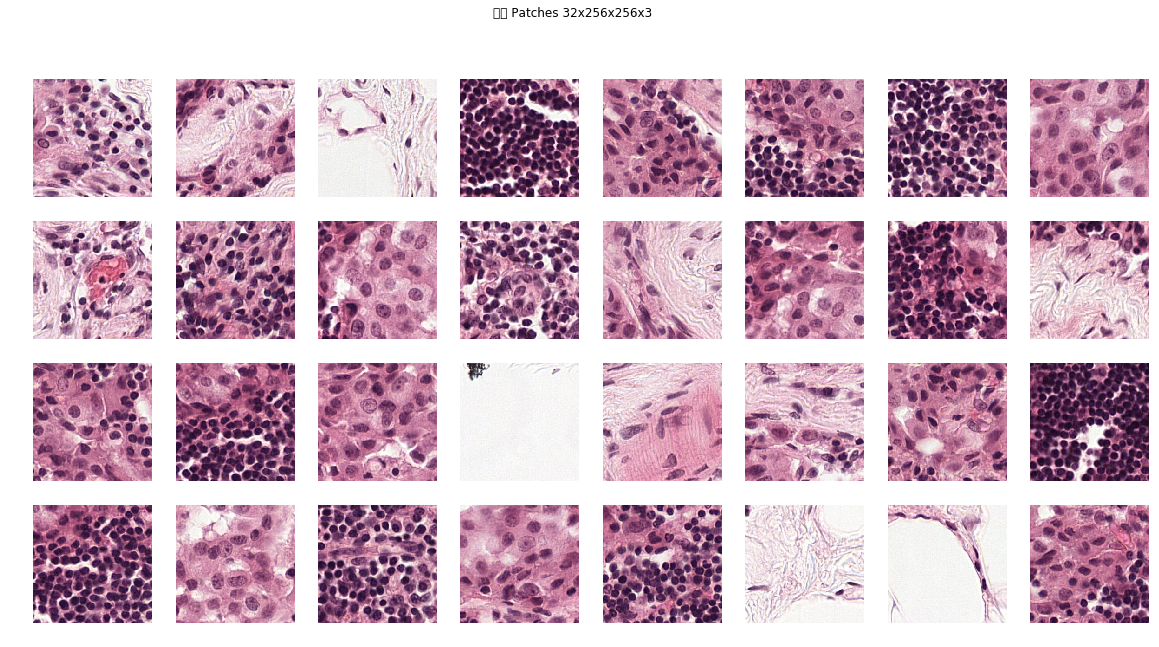

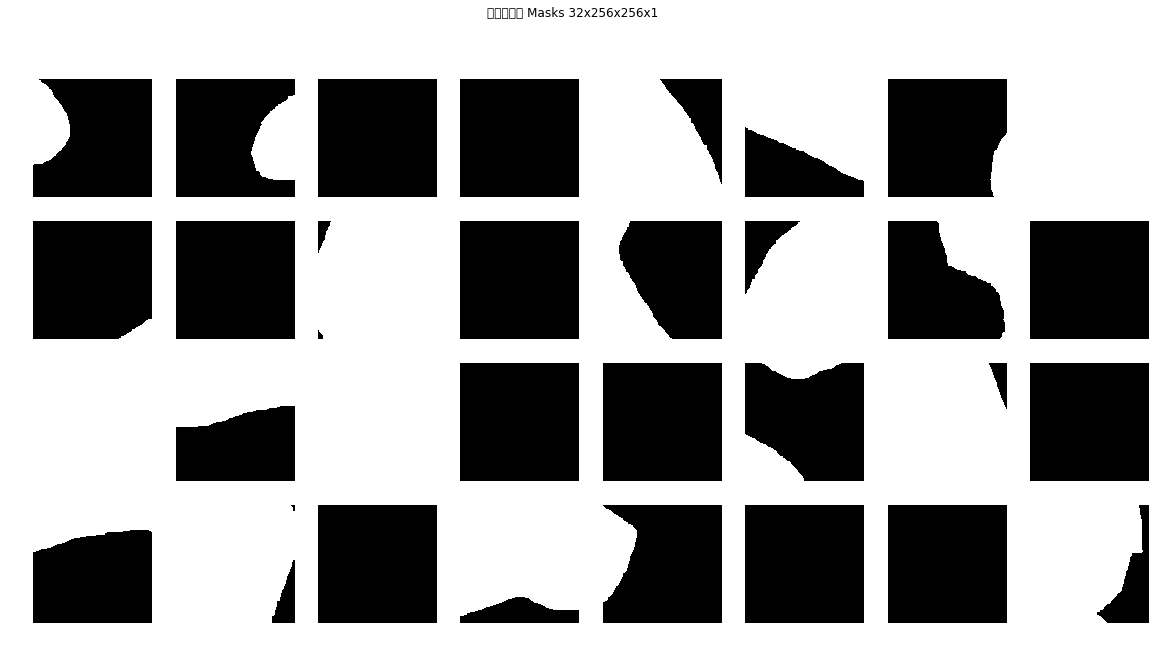

In [10]:
plt.show()

注意尺寸，如同接水管，每个地方的尺寸都要一致，特别是generator

In [12]:
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))    # 输入处理
model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='relu', padding='same'))

model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 100)     2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 200)       180200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 300)       810300    
__________

In [14]:
from datetime import datetime
from keras.callbacks import CSVLogger

epochs = 20

train_start_time = datetime.now()
csvlogger = CSVLogger('training_md.log', append=True)

model.fit_generator(data_generator(),
                    steps_per_epoch=100,
                    epochs=epochs,
                    validation_data=data_generator(),
                    validation_steps=20,
                    verbose=1,
                    workers=10,
                    max_q_size=1,
                    callbacks=[csvlogger])

model.save('model081801.h5')
train_end_time = datetime.now()
print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))

Epoch 1/20
100/100 [==============================] - 286s - loss: 0.3160 - acc: 0.8536 - val_loss: 0.2308 - val_acc: 0.9127
Epoch 2/20
100/100 [==============================] - 271s - loss: 0.1935 - acc: 0.9255 - val_loss: 0.1794 - val_acc: 0.9289
Epoch 3/20
100/100 [==============================] - 277s - loss: 0.1789 - acc: 0.9307 - val_loss: 0.1981 - val_acc: 0.9301
Epoch 4/20
100/100 [==============================] - 265s - loss: 0.1760 - acc: 0.9312 - val_loss: 0.1869 - val_acc: 0.9287
Epoch 5/20
100/100 [==============================] - 267s - loss: 0.1608 - acc: 0.9376 - val_loss: 0.1392 - val_acc: 0.9443
Epoch 6/20
100/100 [==============================] - 275s - loss: 0.1639 - acc: 0.9361 - val_loss: 0.1442 - val_acc: 0.9426
Epoch 7/20
100/100 [==============================] - 259s - loss: 0.1489 - acc: 0.9410 - val_loss: 0.1351 - val_acc: 0.9456
Epoch 8/20
100/100 [==============================] - 272s - loss: 0.1356 - acc: 0.9457 - val_loss: 0.1272 - val_acc: 0.9488


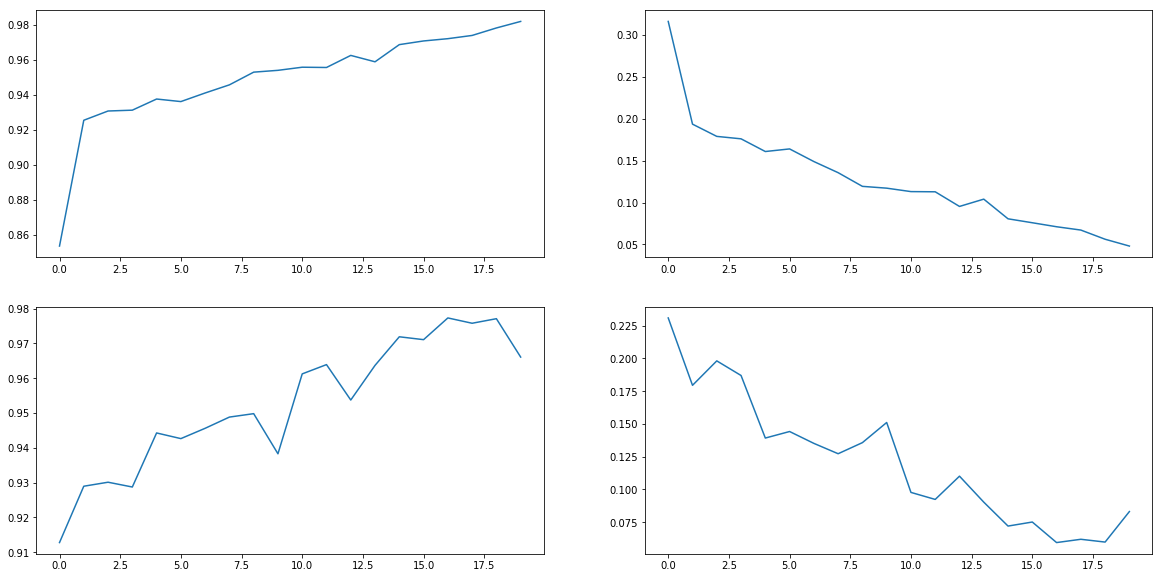

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

train_log = open("training_md.log")
log_line = train_log.readlines()
# log_line
epoch = []
acc = []
loss = []
val_acc = []
val_loss = []

for i in range(len(log_line)):
    if i<20:
        line_list = list(eval(log_line[i+1]))
        epoch.append(line_list[0])
        acc.append(line_list[1])
        loss.append(line_list[2])
        val_acc.append(line_list[3])
        val_loss.append(line_list[4])

fig, axes = plt.subplots(2,2,figsize=(20,10))
ax = axes.ravel()
ax[0].plot(epoch,acc)
ax[1].plot(epoch,loss)
ax[2].plot(epoch,val_acc)
ax[3].plot(epoch,val_loss)

In [17]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

In [18]:
import matplotlib.gridspec as gridspec
from keras.preprocessing import image


def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    pic = image.array_to_img(patch)
    Z1 = pic.convert("L")
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

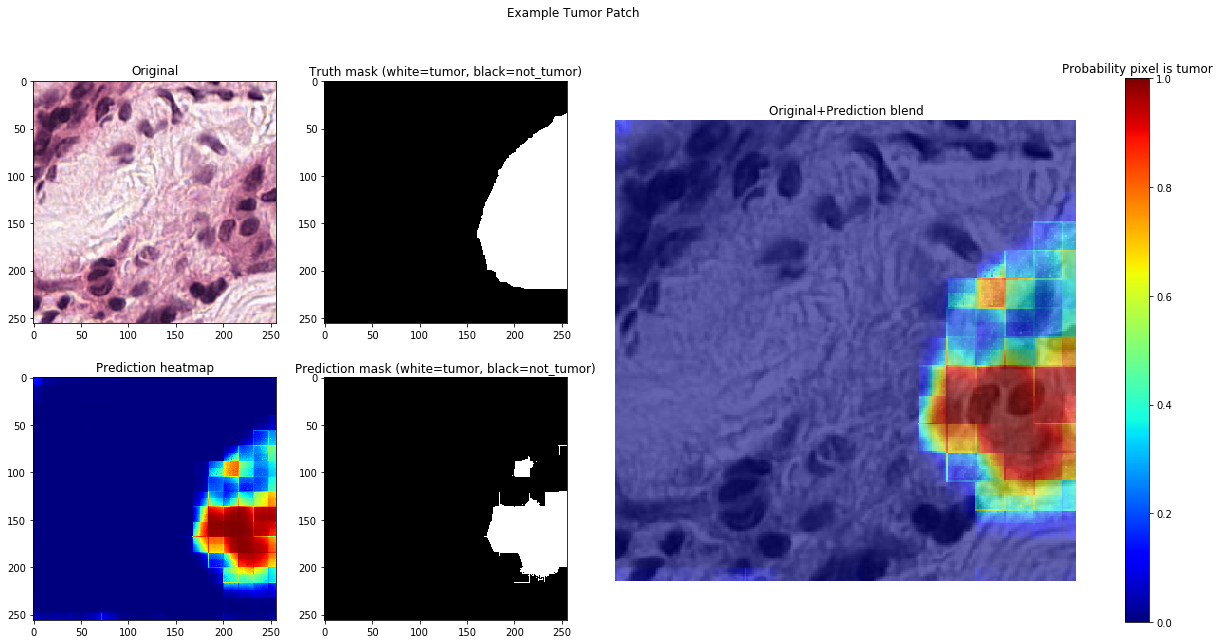

In [23]:
example_patch = example_X[1]
example_truth = example_y[1]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD


def Creat_InvepV3(num_lay_out=1024,classes=2,dropout=0.5):
    img_width, img_height = 299, 299
    base_model = InceptionV3(weights="imagenet", include_top=False,
                             input_shape=(img_width, img_height, 3))
    x = base_model.output
    # x = Flatten()(x)
    # x = Dense(num_lay_out)(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
    # x = Dropout(dropout)(x)
    # x = Dense(classes)(x)
    # x = BatchNormalization()(x)
    # x = Activation('softmax')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_lay_out, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=SGD(lr=0.05, momentum=0.9, decay=0.5),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
from __future__ import division
import keras
from keras.callbacks import CSVLogger
import gc
import time

def train_model():
    keras.backend.tensorflow_backend.clear_session()
    epochs = 20
    model = Creat_InvepV3()
    csvlogger = CSVLogger('training_md.log', append=True)
    model.fit_generator(data_generator(),
                        steps_per_epoch=100,
                        epochs=epochs,
                        validation_data=data_generator(),
                        validation_steps=20,
                        verbose=1,
                        workers=10,
                        max_q_size=1,
                        callbacks=[csvlogger])
    model.save('model_md.h5')
    gc.collect()

start_time = time.clock()
train_model()
end_time = time.clock()
print("模型训练消耗时间： %.1f 分钟"%((end_time - start_time) / 60.0,))

Epoch 1/20


ValueError: Error when checking model target: expected dense_2 to have 2 dimensions, but got array with shape (32, 299, 299, 2)

In [9]:
%time example_X, example_y  = next(data_generator())    # yield要用next调用

0到１之间的随机数是：[ 0.34430525]
CPU times: user 75 ms, sys: 50.2 ms, total: 125 ms
Wall time: 126 ms


In [10]:
example_X.shape

(1, 299, 299, 3)

In [11]:
example_y.shape

(1, 299, 299, 2)

In [12]:
t_patch = example_X[0]
t_patch.shape

(299, 299, 3)

In [31]:
from keras.models import load_model

model_path = 'model.h5'
model = load_model(model_path)

example_patch = example_X[0]
example_truth = example_y[0]

prediction = model.predict(example_patch.reshape(1, 299, 299, 3))
prediction


ValueError: Optimizer weight shape (96,) not compatible with provided weight shape (32,)

In [65]:
prediction

array([[ 0.78259516,  0.21740478]], dtype=float32)

In [69]:
prediction_test = prediction[[:,:],1].reshape(299,299)

SyntaxError: invalid syntax (<ipython-input-69-7e99b9f3be7a>, line 1)

In [34]:
patch = t_patch
# patch

In [35]:
patch.shape

(299, 299, 3)

In [49]:
truth = example_y[0]
truth

array([ 1.,  0.])

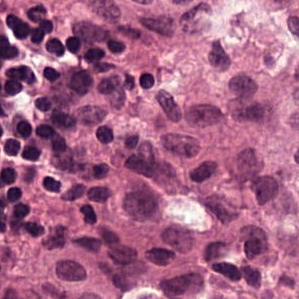

In [39]:
from keras.preprocessing import image

pic = image.array_to_img(patch)
pic

In [47]:
import matplotlib.gridspec as gridspec

def plot_blend(patch, prediction, ax, alpha=0.75):
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.min(x), np.max(x), np.min(y), np.max(y)
    extent = xmin, xmax, ymin, ymax
    # patch.shape
    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = pic.convert("L")
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

In [59]:
truth.argmax(axis=0)

0

In [62]:
import matplotlib.gridspec as gridspec


def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
#     ax1.imshow(truth.argmax(axis=0), cmap='gray', vmin=0, vmax=1);
#     ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')
    fig

In [63]:
plot_patch_with_pred(patch, truth, prediction, title_str='Example Tumor Patch')

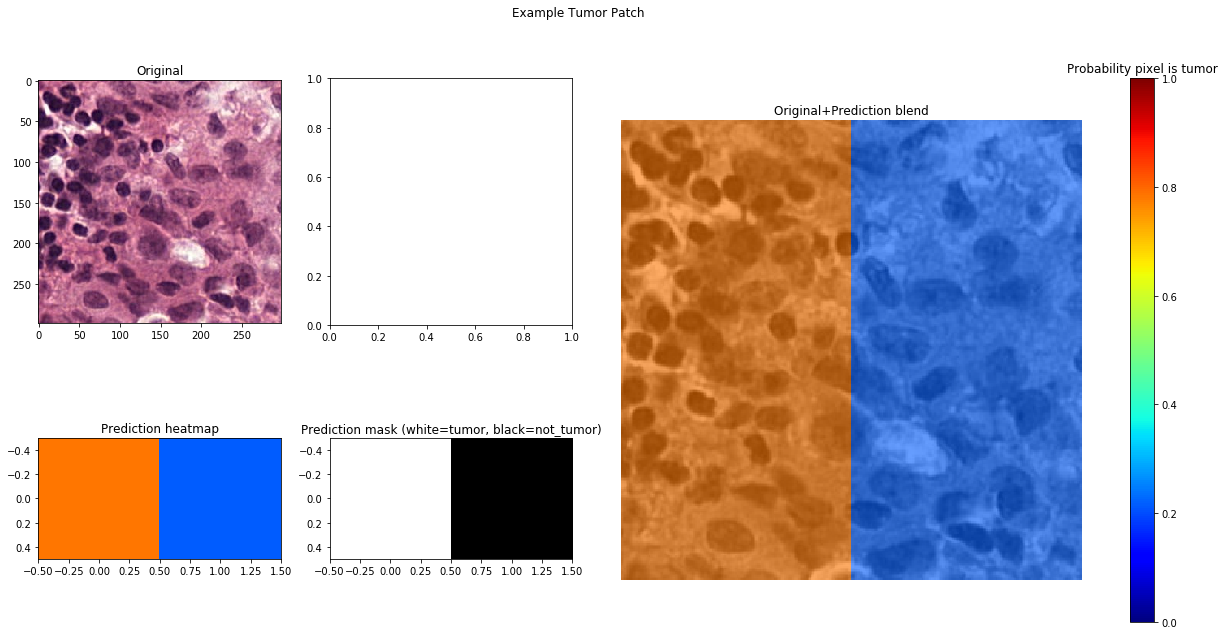

In [64]:
plt.show()

In [ ]:
%time example_X, example_y  = next(data_generator())    # yield要用next调用

In [15]:
example_patch = example_X
example_truth = example_y

model_path = 'model.h5'

prediction = predict_from_model(example_patch, model_path)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

IndexError: too many indices for array

In [ ]:
%time example_X, example_y  = next(data_generator())    # yield要用next调用